# Оптимизация расходов

## Введение

### Описание задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

### Описание процесса обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).


### Описание данных
Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:<br>
`steel.data_arc` — данные об электродах;<br>
`steel.data_bulk` — данные об объёме сыпучих материалов;<br>
`steel.data_bulk_time` — данные о времени подачи сыпучих материалов;<br>
`steel.data_gas` — данные о продувке сплава газом;<br>
`steel.data_temp` — данные об измерениях температуры;<br>
`steel.data_wire` — данные об объёме проволочных материалов;<br>
`steel.data_wire_time` — данные о времени подачи проволочных материалов.

Таблица `steel.data_arc`<br>
`key` - номер партии;<br>
`BeginHeat` - время начала нагрева;<br>
`EndHeat` - время окончания нагрева;<br>
`ActivePower` - значение активной мощности;<br>
`ReactivePower` - значение реактивной мощности.<br>
<br>
Таблица `steel.data_bulk`<br>
`key` - номер партии;<br>
`Bulk1`...`Bulk15` - объём подаваемого материала.<br>
<br>
Таблица `steel.data_bulk_time`<br>
`key` - номер партии;<br>
`Bulk1`...`Bulk15` - время подачи материала.<br>
<br>
Таблица `steel.data_gas`<br>
`key` - номер партии;<br>
`gas` - объём подаваемого газа.<br>
<br>
Таблица `steel.data_temp`<br>
`key` - номер партии;<br>
`MesaureTime` - время замера;<br>
`Temperature` - значение температуры.<br>
<br>
Таблица `steel.data_wire`<br>
`key` - номер партии;<br>
`Wire1`...`Wire9` - объём подаваемых проволочных материалов.<br>
<br>
Таблица `steel.data_wire_time`<br>
`key` - номер партии;<br>
`Wire1`...`Wire9` - время подачи проволочных материалов.<br>
<br>
Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Импорт библиотек

In [13]:
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
import datetime as dt
import shap
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsoluteError

In [14]:
RANDOM_STATE = 42
CLEAR_DATA = False # удалить значения bulk и wire, оставив только суммарные
DROP_ANOMALY = False # Избавиться от аномалий в значениях на этапе загрузки data_arc
ADD_SUM = True # Добавить суммарные значения для bulk и wire

In [15]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    print('Используется GPU для нейронной сети')
else:
    print('Используется CPU для нейронной сети')

Используется CPU для нейронной сети


### Вспомогательные функции

In [16]:
# Информация по датафрейму
def data_frame_info(df,kinds):
    for kind in kinds:
        if kind in [None,'head','H']:
            print('Первые 5 строк данных:')
            display(df.head())

        if kind in [None,'describe','D']:
            print('\nОписание данных:');
            display(df.describe())

        if kind in [None,'info','I']:
            print('\nИнфо:');
            df.info()

        if kind in [None,'missings','M']:
            print('\nНаличие пропусков:');
            missing_props = pd.DataFrame(df.isna().sum())
            missing_props.columns = ['missings']
            missing_props['%'] = round((df.isna().sum()/df.shape[0])*100,3)
            display(missing_props[missing_props.missings > 0].sort_values(by='missings',ascending=False).T)

        if kind in [None,'unique','U']:
            cols = df.select_dtypes(exclude=['number']).columns
            print('\nУникальные значения в категориальных столбцах:')
            for col in cols:
                print(col,':',len(df[col].unique()))
                print(df[col].unique())

        if kind in [None, 'duplicated','DUP']:
            print('\nКоличество дубликатов в данных:', df.duplicated().sum())

# Графики числовых признаков
def plots_hist_box(df):
    numeric_cols = df.select_dtypes(include=['number']).columns

    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 3*num_plots))

    for i, col in enumerate(numeric_cols):
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Количество значений')

        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Распределение {col}')

    plt.tight_layout()
    plt.show()

# Функция приводит названия столбцов в таблице к pep8
def cols_names_to_pep8(df,type_name,suffics,date_format = '%Y-%m-%d %H:%M:%S'):
    column_names = df.drop('key',axis=1)
    if (type_name == float) | (type_name == int):
        for name in column_names:
            df[str(name).lower().replace(' ','_')+suffics] = df[name].astype(type_name)

    if type_name == 'datetime':
        for name in column_names:
            df[str(name).lower().replace(' ','_')+suffics] = pd.to_datetime(df[name], format=date_format)
    df.drop(columns=column_names,axis=1,inplace=True)

    return df

# дельта значений в строке
def difference(row):
    return row.max() - row.min()

# Разделение выборки на тренировочную и валидационную
def data_split(data, target, valid_size):
    # data - dataframe
    # target - target feature
    # valid_size - train and valid proportion
    features = data.drop([target] , axis=1)
    target = data[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=valid_size, random_state=RANDOM_STATE)

    return features_train, features_valid, target_train, target_valid

## Загрузка данных

In [17]:
!curl -O https://code.s3.yandex.net/data-scientist/ds-plus-final.db

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3504k  100 3504k    0     0  1031k      0  0:00:03  0:00:03 --:--:-- 1032k


In [18]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

### data_arc

In [19]:
# Загрузка и сохранение таблицы 'steel.data_arc'
query = '''
SELECT *
FROM data_arc
'''
data_arc_df = pd.read_sql_query(query, con=engine)
data_frame_info(data_arc_df,['head','describe','info','missings'])

Первые 5 строк данных:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



Описание данных:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Наличие пропусков:


""
missings
%


In [20]:
# Переименуем столбцы согласно pep8
data_arc_df.columns = ['key','start_heating_time','stop_heating_time','active_power','reactive_power']

# В данных присутствует выброс с отрицательным значением в столбце реактивной мощности, заменим его медианным значением
rp_median = data_arc_df[data_arc_df['reactive_power'] > 0]['reactive_power'].median()
data_arc_df['reactive_power'] = data_arc_df['reactive_power'].apply(lambda x: rp_median if x < 0 else x)

# Преобразуем временные столбцы в правильный тип
data_arc_df['start_heating_time'] = pd.to_datetime(data_arc_df['start_heating_time'], format='%Y-%m-%d %H:%M:%S')
data_arc_df['stop_heating_time'] = pd.to_datetime(data_arc_df['stop_heating_time'], format='%Y-%m-%d %H:%M:%S')

# Посчитаем время нагрева в секундах
data_arc_df['heating_time'] = ((data_arc_df['stop_heating_time']-data_arc_df['start_heating_time'])/1e9).astype(int)
display(data_arc_df.head())

,key,start_heating_time,stop_heating_time,active_power,reactive_power,heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


In [21]:
# Посчитаем количество циклов нагрева, сумарное время нагрева общее количество затраченной энергии
data_arc_fixed_df = data_arc_df.pivot_table(index='key',
                                            values=['active_power','reactive_power','heating_time'],
                                            aggfunc='sum')

data_arc_fixed_df = data_arc_fixed_df.merge(data_arc_df.pivot_table(index='key',
                                                                    values='active_power',
                                                                    aggfunc='count'),
                                            on='key')
data_arc_fixed_df.rename(columns={'active_power_x':'active_power',
                                  'active_power_y':'heating_cycles'},inplace=True)

# Посчитаем полную мощность, Power Factor и работу как произведение мощности на время
data_arc_fixed_df['total_power'] = (data_arc_fixed_df['active_power']**2 + data_arc_fixed_df['reactive_power']**2)**0.5
data_arc_fixed_df['power_factor'] = data_arc_fixed_df['active_power']/data_arc_fixed_df['total_power']
data_arc_fixed_df['work'] = data_arc_fixed_df['total_power']*data_arc_fixed_df['heating_time']

#data_arc_fixed_df['key'] = data_arc_fixed_df.index
data_arc_fixed_df.head()
# Отсортируем по времени нагрева
print('Самые короткие плавки')
display(data_arc_fixed_df.sort_values(by='heating_time').head())
print('Самые длинные плавки')
display(data_arc_fixed_df.sort_values(by='heating_time').tail())
print('Размер выборки',data_arc_fixed_df.shape)

Самые короткие плавки


,active_power,heating_time,reactive_power,heating_cycles,total_power,power_factor,work
key,,,,,,,
977,0.485501,57,0.390823,1,0.623261,0.778969,35.525857
943,0.429304,61,0.340649,1,0.548036,0.783350,33.430208
1766,0.840999,64,0.756034,1,1.130870,0.743674,72.375673
112,0.633449,95,0.432308,1,0.766908,0.825978,72.856258
1988,0.463010,107,0.312275,1,0.558475,0.829062,59.756788


Самые длинные плавки


,active_power,heating_time,reactive_power,heating_cycles,total_power,power_factor,work
key,,,,,,,
322,8.914806,2658,6.564143,13,11.070761,0.805257,29426.081564
2108,10.706804,2739,7.589489,16,13.123871,0.815827,35946.283207
1880,6.149070,2755,4.263111,11,7.482324,0.821813,20613.803508
46,9.180259,2919,7.051945,13,11.576143,0.793033,33790.761018
1689,12.375636,4189,8.949049,15,15.272257,0.810334,63975.486018


Размер выборки (3214, 7)


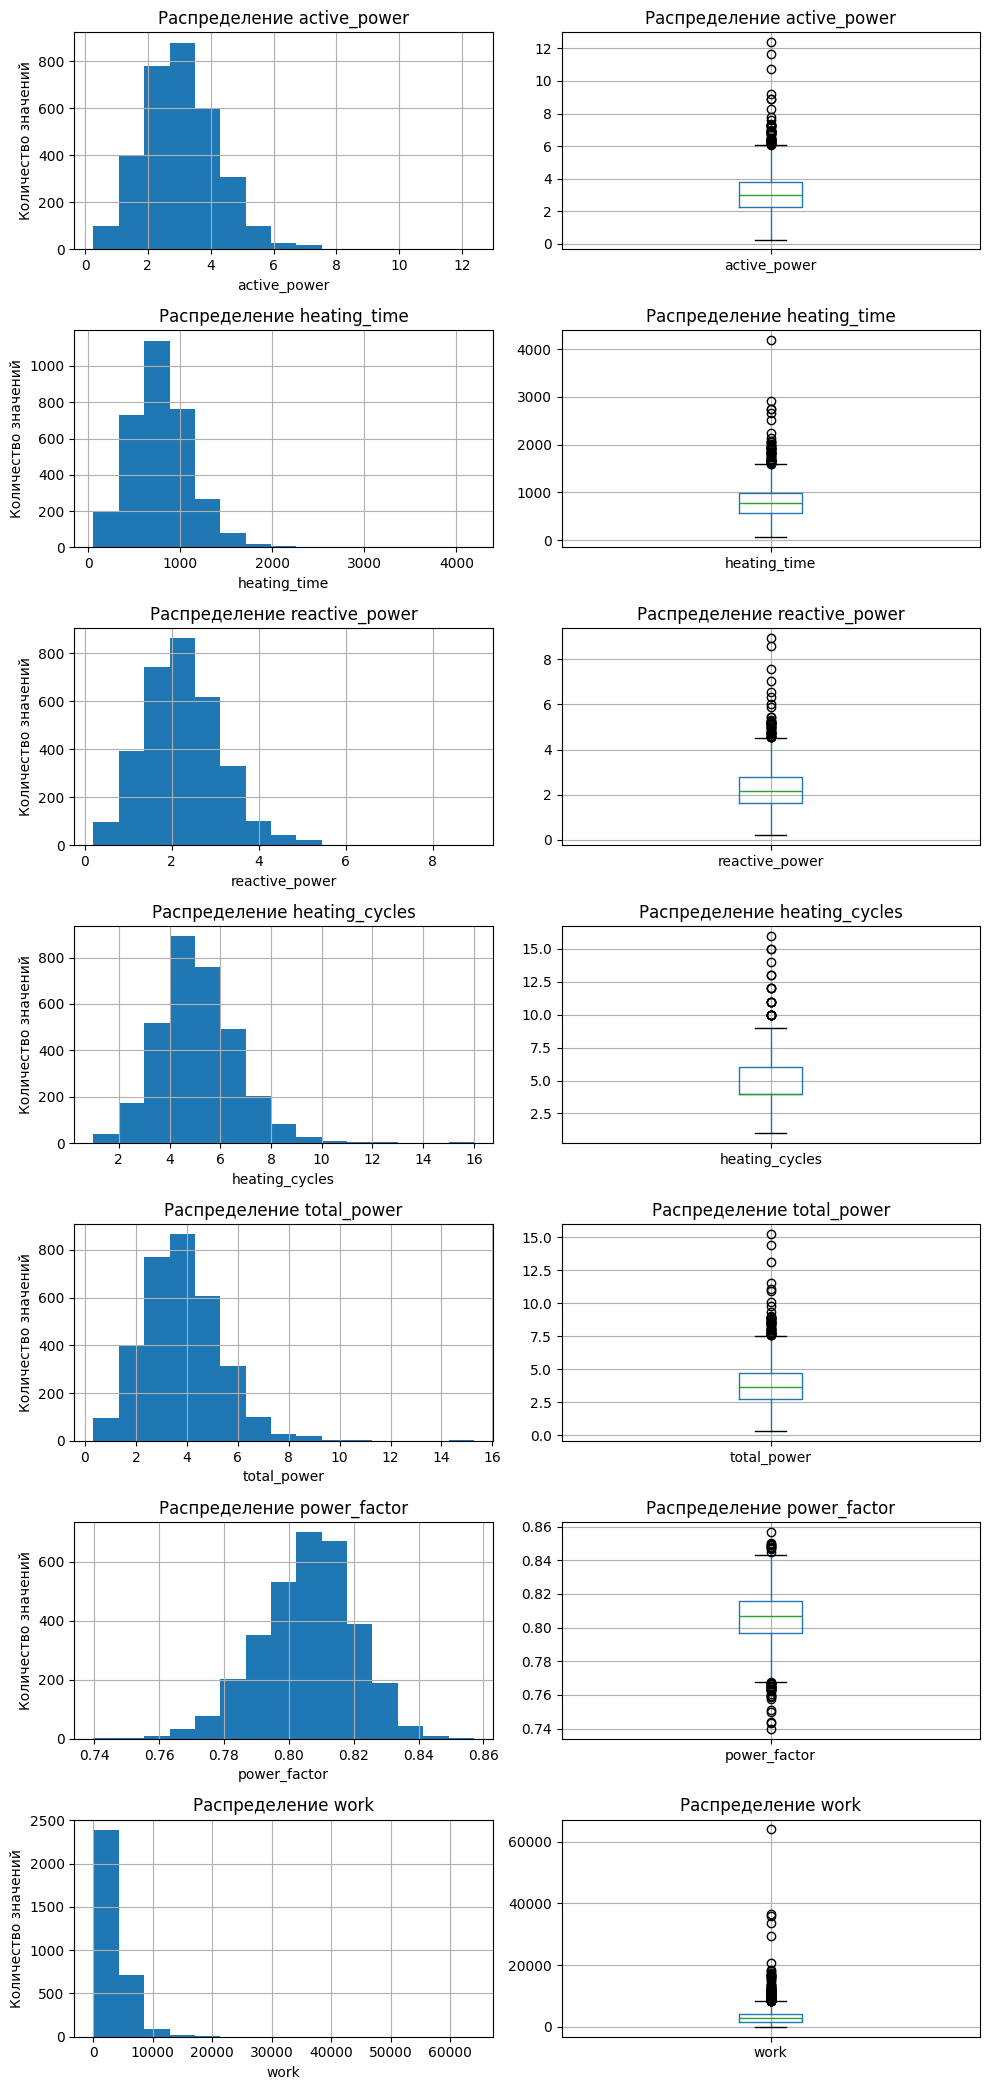

In [22]:
plots_hist_box(data_arc_fixed_df)

Анализ показывает наличие явно неэффективных плавок с чрезмерным потреблением энергии и аномальным числом подогревов. В этой связи целесообразно исключить значения, выходящие за пределы «усов» boxplot.

In [23]:
if DROP_ANOMALY:
    data_arc_fixed_df = data_arc_fixed_df[(data_arc_fixed_df['active_power'] < 8) &
                                     (data_arc_fixed_df['heating_time'] < 2000) & (data_arc_fixed_df['heating_time'] > 60) &
                                     (data_arc_fixed_df['reactive_power'] < 5) &
                                     (data_arc_fixed_df['heating_cycles'] < 10) & (data_arc_fixed_df['heating_cycles'] > 2) &
                                     (data_arc_fixed_df['total_power'] < 8) &
                                     (data_arc_fixed_df['power_factor'] > 0.76) &
                                     (data_arc_fixed_df['work'] < 8000)
                                    ]
    print(data_arc_fixed_df.shape)
    plots_hist_box(data_arc_fixed_df)


### data_bulk

In [24]:
# Загрузка и сохранение таблицы 'steel.data_bulk'
query = '''
SELECT *
FROM data_bulk
'''

data_bulk_df = pd.read_sql_query(query, con=engine)
data_frame_info(data_bulk_df,['H','I'])

Первые 5 строк данных:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


Видно, что у части столбцов некорректно задан тип данных. Пройдёмся по ним и приведём типы к нужным.

In [25]:
data_bulk_df = cols_names_to_pep8(data_bulk_df,float,'')
data_frame_info(data_bulk_df,['I','M'])


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB

Наличие пропусков:


,bulk_8,bulk_13,bulk_9,bulk_2,bulk_7,bulk_5,bulk_10,bulk_11,bulk_1,bulk_6,bulk_4,bulk_3,bulk_15,bulk_12,bulk_14
missings,3128.000,3111.000,3110.000,3107.000,3104.000,3052.000,2953.000,2952.000,2877.000,2553.000,2115.000,1831.000,881.000,679.0,323.000
%,99.968,99.425,99.393,99.297,99.201,97.539,94.375,94.343,91.946,81.592,67.593,58.517,28.156,21.7,10.323


Наблюдается большое количество пропусков. Поскольку отсутствие значения означает, что материал не добавлялся, корректно заменить такие пропуски нулём.

In [26]:
data_bulk_df.replace(np.nan,0,inplace=True)
data_frame_info(data_bulk_df,['H','D','I','M'])

Первые 5 строк данных:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0



Описание данных:


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB

Наличие пропусков:


""
missings
%


In [27]:
# Добавление столбца с суммой
if ADD_SUM:
    column_names = data_bulk_df.drop('key',axis = 1).columns
    data_bulk_df['bulk_sum'] = data_bulk_df[column_names].apply(lambda x: sum(x),axis=1)
    if CLEAR_DATA:
        data_bulk_df.drop(columns = column_names,axis=1,inplace=True)
    display(data_bulk_df.head())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


Теперь всё корректно, можно переходить к следующему шагу.

### data_bulk_time

In [28]:
# Загрузка и сохранение таблицы 'steel.data_bulk'
query = '''
SELECT *
FROM data_bulk_time
'''
data_bulk_time_df = pd.read_sql_query(query, con=engine)
data_frame_info(data_bulk_time_df,['H','I'])

Первые 5 строк данных:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


In [29]:
# Поправим в нужных столбцах тип данных
data_bulk_time_df = cols_names_to_pep8(data_bulk_time_df,'datetime','_time')
data_frame_info(data_bulk_time_df,['H','I'])

Первые 5 строк данных:


,key,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   bulk_1_time   252 non-null    datetime64[ns]
 2   bulk_2_time   22 non-null     datetime64[ns]
 3   bulk_3_time   1298 non-null   datetime64[ns]
 4   bulk_4_time   1014 non-null   datetime64[ns]
 5   bulk_5_time   77 non-null     datetime64[ns]
 6   bulk_6_time   576 non-null    datetime64[ns]
 7   bulk_7_time   25 non-null     datetime64[ns]
 8   bulk_8_time   1 non-null      datetime64[ns]
 9   bulk_9_time   19 non-null     datetime64[ns]
 10  bulk_10_time  176 non-null    datetime64[ns]
 11  bulk_11_time  177 non-null    datetime64[ns]
 12  bulk_12_time  2450 non-null   datetime64[ns]
 13  bulk_13_time  18 non-null     datetime64[ns]
 14  bulk_14_time  2806 non-null   datetime64[ns]
 15  bulk_15_time  2248 non-null   d

Рассчитаем временной интервал между первым и последним добавлением материала и оценим его корректность.

In [30]:
data_bulk_time_df['bulk_duration'] = data_bulk_time_df.drop('key', axis=1).apply(difference, axis = 1)

In [31]:
data_bulk_time_df.sort_values(by='bulk_duration').tail()

,key,bulk_1_time,bulk_2_time,bulk_3_time,bulk_4_time,bulk_5_time,bulk_6_time,bulk_7_time,bulk_8_time,bulk_9_time,bulk_10_time,bulk_11_time,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time,bulk_duration
2470,2562,2019-08-12 19:51:09,2019-08-12 21:42:20,NaT,2019-08-12 21:23:19,2019-08-12 21:20:02,NaT,2019-08-12 20:24:56,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 01:51:11
2859,2965,NaT,NaT,NaT,2019-08-28 05:41:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-28 05:32:52,NaT,2019-08-28 05:26:34,2019-08-28 03:40:56,0 days 02:00:38
1818,1880,NaT,NaT,2019-07-12 10:21:30,NaT,NaT,2019-07-12 10:13:21,NaT,NaT,NaT,NaT,2019-07-12 09:06:13,2019-07-12 08:06:14,NaT,2019-07-12 07:52:20,2019-07-12 07:45:54,0 days 02:35:36
1819,1881,NaT,NaT,2019-07-12 13:55:14,NaT,NaT,2019-07-12 13:48:37,NaT,NaT,NaT,NaT,2019-07-12 13:43:25,2019-07-12 13:28:04,NaT,2019-07-12 10:56:50,2019-07-12 10:42:42,0 days 03:12:32
1895,1958,NaT,NaT,2019-07-21 14:44:03,NaT,NaT,2019-07-21 14:39:15,NaT,NaT,NaT,NaT,NaT,2019-07-21 14:31:46,NaT,2019-07-21 14:27:11,2019-07-21 10:56:00,0 days 03:48:03


### data_gas

In [32]:
# Загрузка и сохранение таблицы 'steel.data_bulk'
query = '''
SELECT *
FROM data_gas
'''
data_gas_df = pd.read_sql_query(query, con=engine)
data_frame_info(data_gas_df,['head','describe','info'])

Первые 5 строк данных:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Описание данных:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


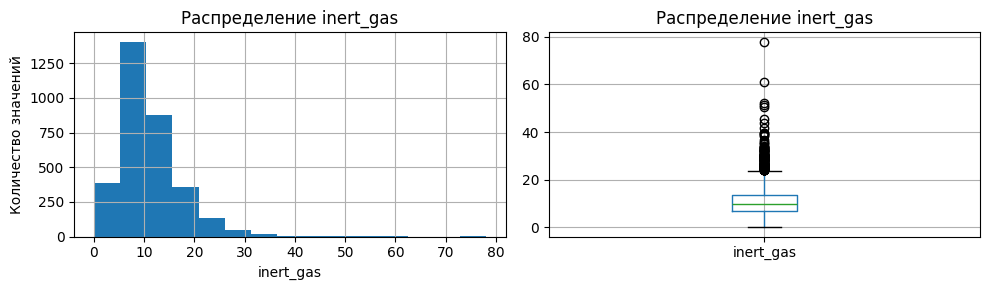

In [33]:
# Поправим название столбца
data_gas_df.columns = ['key','inert_gas']
plots_hist_box(data_gas_df.drop('key',axis=1))

### data_temp

In [34]:
# Загрузка и сохранение таблицы 'steel.data_bulk'
query = '''
SELECT *
FROM data_temp
'''
data_temp_df = pd.read_sql_query(query, con=engine)
data_frame_info(data_temp_df,['head','info'])

Первые 5 строк данных:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


In [35]:
# Переименуем столбцы
data_temp_df.columns = ['key','timestamp','temperature']
# Приведем типы столбцов в порядок
data_temp_df['timestamp'] = pd.to_datetime(data_temp_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
data_temp_df['temperature'] = data_temp_df['temperature'].astype(float)
data_frame_info(data_temp_df,['info','M'])
# Заполним пропуски нулями
data_temp_df.fillna(0,inplace=True)
data_frame_info(data_temp_df,['M'])


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18092 non-null  int64         
 1   timestamp    18092 non-null  datetime64[ns]
 2   temperature  14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB

Наличие пропусков:


,temperature
missings,3427.000
%,18.942



Наличие пропусков:


""
missings
%


Заказчик сообщил, что значения температуры ниже 1500 °C следует считать аномальными.

In [36]:
data_temp_df = data_temp_df[data_temp_df['temperature'] >= 1500]

In [37]:
# Выделим время начала замера температуры и конец
data_temp_fixed_df = data_temp_df.pivot_table(index='key',
                                            values=['timestamp','temperature'],
                                            aggfunc=['min','max'])
data_temp_fixed_df.columns = ['start_temp','start_time','final_temp','final_time']
data_frame_info(data_temp_fixed_df,['H','D'])

Первые 5 строк данных:


,start_temp,start_time,final_temp,final_time
key,,,,
1,1571.0,2019-05-03 11:02:04,1618.0,2019-05-03 11:30:38
2,1577.0,2019-05-03 11:34:04,1604.0,2019-05-03 11:55:09
3,1596.0,2019-05-03 12:06:44,1600.0,2019-05-03 12:35:57
4,1601.0,2019-05-03 12:39:27,1625.0,2019-05-03 12:59:47
5,1576.0,2019-05-03 13:11:03,1602.0,2019-05-03 13:36:39



Описание данных:


,start_temp,start_time,final_temp,final_time
count,3215.000000,3215,3215.000000,3215
mean,1581.322551,2019-07-05 18:12:11.554587904,1600.068740,2019-07-05 18:41:26.665318656
min,1515.000000,2019-05-03 11:02:04,1529.000000,2019-05-03 11:30:38
25%,1569.000000,2019-06-04 08:07:51.500000,1589.000000,2019-06-04 09:05:04
50%,1581.000000,2019-07-03 04:35:28,1598.000000,2019-07-03 05:19:58
75%,1592.000000,2019-08-07 23:34:21.500000,1611.000000,2019-08-08 00:08:41
max,1684.000000,2019-09-06 16:48:55,1705.000000,2019-09-06 16:48:55
std,20.642289,NaN,20.968787,NaN


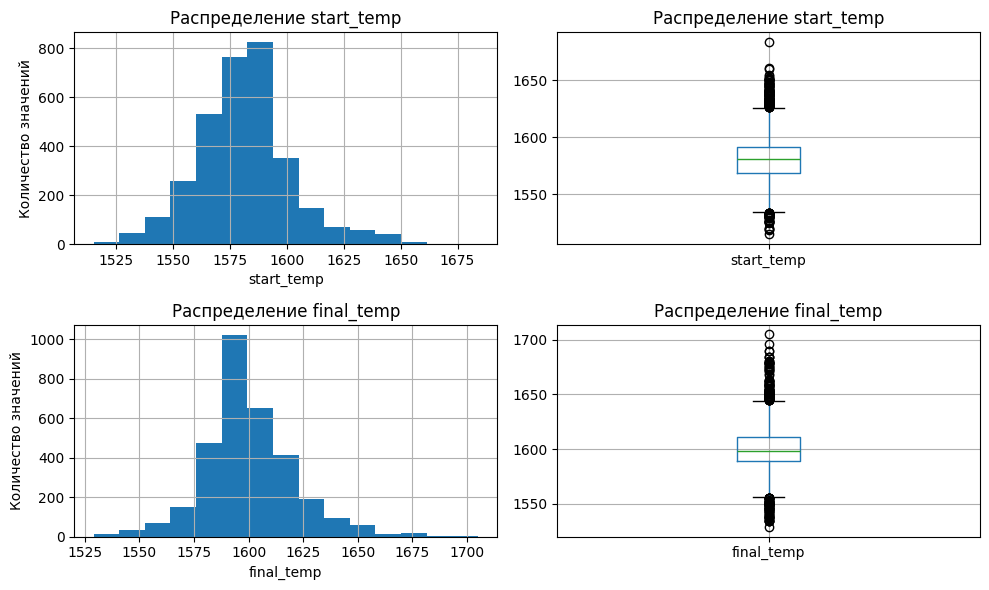

In [38]:
plots_hist_box(data_temp_fixed_df[['start_temp','final_temp']])

### data_wire

In [39]:
# Загрузка и сохранение таблицы 'steel.data_bulk'
query = '''
SELECT *
FROM data_wire
'''
data_wire_df = pd.read_sql_query(query, con=engine)
data_frame_info(data_wire_df,['head','info'])

Первые 5 строк данных:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


In [40]:
# Поправим типы данных в колонках и приведем названия к pep8
column_names = data_wire_df.drop('key',axis=1).columns
for name in column_names:
    data_wire_df[str(name).lower().replace(' ','_')] = data_wire_df[name].astype(float)
data_wire_df.drop(columns=column_names,axis=1,inplace=True)


data_wire_df.fillna(0,inplace=True)
data_frame_info(data_wire_df,['head','info','D'])

Первые 5 строк данных:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Описание данных:


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


In [41]:
# Добавление суммы по столбцам
if ADD_SUM:
    column_names = data_wire_df.drop('key',axis = 1).columns
    data_wire_df['wire_sum'] = data_wire_df[column_names].apply(lambda x: sum(x),axis=1)
    if CLEAR_DATA:
        data_wire_df.drop(columns = column_names,axis=1,inplace=True)
    display(data_wire_df.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


### data_wire_time

In [42]:
# Загрузка и сохранение таблицы 'steel.data_bulk'
query = '''
SELECT *
FROM data_wire_time
'''
data_wire_time_df = pd.read_sql_query(query, con=engine)
data_frame_info(data_wire_time_df,['head','info'])

Первые 5 строк данных:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [43]:
# Поправим типы данных в колонках и приведем названия к pep8
data_wire_time_df = cols_names_to_pep8(data_wire_time_df,'datetime','_time')

data_frame_info(data_wire_time_df,['head','info'])

Первые 5 строк данных:


,key,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int64         
 1   wire_1_time  3055 non-null   datetime64[ns]
 2   wire_2_time  1079 non-null   datetime64[ns]
 3   wire_3_time  63 non-null     datetime64[ns]
 4   wire_4_time  14 non-null     datetime64[ns]
 5   wire_5_time  1 non-null      datetime64[ns]
 6   wire_6_time  73 non-null     datetime64[ns]
 7   wire_7_time  11 non-null     datetime64[ns]
 8   wire_8_time  19 non-null     datetime64[ns]
 9   wire_9_time  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [44]:
# Посмотрим на разницу во времени между добавлениями присадочных проволок
data_wire_time_df['wire_duration'] = data_wire_time_df.drop('key', axis=1).apply(difference, axis = 1)
data_wire_time_df.sort_values(by='wire_duration',ascending=False).head()

,key,wire_1_time,wire_2_time,wire_3_time,wire_4_time,wire_5_time,wire_6_time,wire_7_time,wire_8_time,wire_9_time,wire_duration
2012,2110,2019-07-27 20:50:19,NaT,2019-07-27 20:02:21,2019-07-27 19:41:36,NaT,2019-07-27 19:15:43,2019-07-27 19:11:22,NaT,NaT,0 days 01:38:57
2010,2108,2019-07-27 15:15:04,NaT,2019-07-27 14:05:34,2019-07-27 13:57:58,NaT,2019-07-27 13:48:37,2019-07-27 13:43:32,NaT,NaT,0 days 01:31:32
2439,2566,2019-08-13 04:15:39,NaT,2019-08-13 03:21:46,2019-08-13 03:16:45,NaT,2019-08-13 03:04:56,2019-08-13 02:52:06,NaT,NaT,0 days 01:23:33
2440,2567,2019-08-13 07:10:14,NaT,2019-08-13 07:04:38,NaT,2019-08-13 06:14:30,2019-08-13 06:10:36,NaT,NaT,NaT,0 days 00:59:38
97,113,2019-05-07 15:44:02,NaT,2019-05-07 15:39:35,2019-05-07 15:19:17,NaT,2019-05-07 14:46:05,NaT,NaT,NaT,0 days 00:57:57


## Объединение таблиц

In [45]:
'''
+data_arc_fixed_df
+data_bulk_df
+data_bulk_time_df
+data_gas_df
+data_temp_fixed_df
+data_wire_df
+data_wire_time_df
'''
data_df = data_arc_fixed_df
for df in [data_wire_df, data_wire_time_df, data_bulk_df, data_bulk_time_df, data_temp_fixed_df, data_gas_df]:
    data_df = data_df.merge(df,on='key')

data_frame_info(data_df,['I','H','M'])


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   key             3021 non-null   int64          
 1   active_power    3021 non-null   float64        
 2   heating_time    3021 non-null   int64          
 3   reactive_power  3021 non-null   float64        
 4   heating_cycles  3021 non-null   int64          
 5   total_power     3021 non-null   float64        
 6   power_factor    3021 non-null   float64        
 7   work            3021 non-null   float64        
 8   wire_1          3021 non-null   float64        
 9   wire_2          3021 non-null   float64        
 10  wire_3          3021 non-null   float64        
 11  wire_4          3021 non-null   float64        
 12  wire_5          3021 non-null   float64        
 13  wire_6          3021 non-null   float64        
 14  wire_7          3021 non-null   f

,key,active_power,heating_time,reactive_power,heating_cycles,total_power,power_factor,work,wire_1,wire_2,...,bulk_12_time,bulk_13_time,bulk_14_time,bulk_15_time,bulk_duration,start_temp,start_time,final_temp,final_time,inert_gas
0,1,3.036730,1098,2.142821,5,3.716640,0.817063,4080.870431,60.059998,0.00000,...,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,0 days 00:18:05,1571.0,2019-05-03 11:02:04,1618.0,2019-05-03 11:30:38,29.749986
1,2,2.139408,811,1.453357,4,2.586371,0.827185,2097.546600,96.052315,0.00000,...,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,0 days 00:16:40,1577.0,2019-05-03 11:34:04,1604.0,2019-05-03 11:55:09,12.555561
2,3,4.063641,655,2.937457,5,5.014163,0.810433,3284.276844,91.160157,0.00000,...,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,0 days 00:16:23,1596.0,2019-05-03 12:06:44,1600.0,2019-05-03 12:35:57,28.554793
3,4,2.706489,741,2.056992,4,3.399456,0.796154,2518.996645,89.063515,0.00000,...,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,0 days 00:14:38,1601.0,2019-05-03 12:39:27,1625.0,2019-05-03 12:59:47,18.841219
4,5,2.252950,869,1.687991,4,2.815155,0.800293,2446.369640,89.238236,9.11456,...,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,0 days 00:03:25,1576.0,2019-05-03 13:11:03,1602.0,2019-05-03 13:36:39,5.413692



Наличие пропусков:


,wire_5_time,bulk_8_time,wire_7_time,wire_4_time,bulk_13_time,bulk_9_time,wire_8_time,bulk_2_time,bulk_7_time,wire_9_time,...,bulk_11_time,bulk_1_time,bulk_6_time,bulk_4_time,wire_2_time,bulk_3_time,bulk_15_time,bulk_12_time,bulk_14_time,wire_1_time
missings,3020.000,3020.000,3010.000,3007.000,3003.000,3002.000,3002.000,2999.000,2997.000,2996.000,...,2844.000,2769.000,2451.000,2010.000,1970.00,1728.0,788.000,666.000,313.000,25.000
%,99.967,99.967,99.636,99.537,99.404,99.371,99.371,99.272,99.206,99.172,...,94.141,91.658,81.132,66.534,65.21,57.2,26.084,22.046,10.361,0.828


In [46]:
print('data_arc_fixed_df',data_arc_fixed_df.shape[0])
print('data_bulk_df',data_bulk_df.shape[0])
print('data_bulk_time_df',data_bulk_time_df.shape[0])
print('data_gas_df',data_gas_df.shape[0])
print('data_temp_fixed_df',data_temp_fixed_df.shape[0])
print('data_wire_df',data_wire_df.shape[0])
print('data_wire_time_df',data_wire_time_df.shape[0])
print('data_df',data_df.shape[0])

data_arc_fixed_df 3214
data_bulk_df 3129
data_bulk_time_df 3129
data_gas_df 3239
data_temp_fixed_df 3215
data_wire_df 3081
data_wire_time_df 3081
data_df 3021


In [47]:
# 62 признака (включая целевой) — избыточно, сократим размерность.
# Предположим, что точные временные метки начала отдельных этапов нам не критичны,
# и вместо них достаточно использовать общую продолжительность процесса.
# Также не учитываем календарный месяц выполнения плавки.
# Временные признаки агрегируем в один показатель — общее время процесса.

# Выделим столбцы с типом datetime
datetime_columns = data_df.select_dtypes('datetime').columns
# посчитаем общее время процесса как разницу между самым ранним временем и самым поздним
data_df['process_duration'] = data_df[datetime_columns].apply(difference, axis = 1)
# избавимся от теперь уже не нужных колонок
data_df.drop(columns = datetime_columns, axis = 1, inplace = True)
# также удалим созданные временные столбцы для оценки адекватности длительности подачи проволок и легирующих материалов
data_df.drop(columns = ['wire_duration','bulk_duration'],axis = 1, inplace = True)
# Время будем считать в секундах
data_df['process_duration'] = (data_df['process_duration']*1e-9).astype(int)

data_frame_info(data_df,['I','H'])


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3021 non-null   int64  
 1   active_power      3021 non-null   float64
 2   heating_time      3021 non-null   int64  
 3   reactive_power    3021 non-null   float64
 4   heating_cycles    3021 non-null   int64  
 5   total_power       3021 non-null   float64
 6   power_factor      3021 non-null   float64
 7   work              3021 non-null   float64
 8   wire_1            3021 non-null   float64
 9   wire_2            3021 non-null   float64
 10  wire_3            3021 non-null   float64
 11  wire_4            3021 non-null   float64
 12  wire_5            3021 non-null   float64
 13  wire_6            3021 non-null   float64
 14  wire_7            3021 non-null   float64
 15  wire_8            3021 non-null   float64
 16  wire_9            3021 non-null   f

,key,active_power,heating_time,reactive_power,heating_cycles,total_power,power_factor,work,wire_1,wire_2,...,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,start_temp,final_temp,inert_gas,process_duration
0,1,3.036730,1098,2.142821,5,3.716640,0.817063,4080.870431,60.059998,0.00000,...,0.0,206.0,0.0,150.0,154.0,553.0,1571.0,1618.0,29.749986,1714
1,2,2.139408,811,1.453357,4,2.586371,0.827185,2097.546600,96.052315,0.00000,...,0.0,206.0,0.0,149.0,154.0,582.0,1577.0,1604.0,12.555561,1265
2,3,4.063641,655,2.937457,5,5.014163,0.810433,3284.276844,91.160157,0.00000,...,0.0,205.0,0.0,152.0,153.0,544.0,1596.0,1600.0,28.554793,1753
3,4,2.706489,741,2.056992,4,3.399456,0.796154,2518.996645,89.063515,0.00000,...,0.0,207.0,0.0,153.0,154.0,595.0,1601.0,1625.0,18.841219,1220
4,5,2.252950,869,1.687991,4,2.815155,0.800293,2446.369640,89.238236,9.11456,...,0.0,203.0,0.0,151.0,152.0,584.0,1576.0,1602.0,5.413692,1536


In [48]:
# Учитываем предметную область: в каждой партии добавлялись сыпучие и проволочные материалы,
# выполнялась продувка газом и осуществлялся нагрев сплава.
# Проверим датафрейм на наличие строк, противоречащих этим условиям.
# Рассмотрим возможную альтернативную интерпретацию данных.
if CLEAR_DATA:
    # удалить значения bulk и wire, оставив только суммарные
    wrong_rows_count = data_df[
                        (data_df['wire_sum'] <= 0) |
                        (data_df['bulk_sum'] <= 0) |
                        (data_df['inert_gas'] <= 0) |
                        (data_df['heating_time'] <= 0)]['key'].count()
    if wrong_rows_count > 0:
        print('Найдено строк не подходящих под критерий:',wrong_rows_count)
        wrong_rows = data_df[
                    (data_df['wire_sum'] <= 0) |
                    (data_df['bulk_sum'] <= 0) |
                    (data_df['inert_gas'] <= 0) |
                    (data_df['heating_time'] <= 0)]
        display(wrong_rows)

        data_df.drop(index=wrong_rows.index.values, axis=0, inplace = True)
        print('Строки не подходящие по критерию удалены!')
    else:
        print('Строк не подходящих под критерии не найдено!')
else:
    wrong_rows_count = data_df[(data_df[data_df.columns[17:31]].sum(axis=1) <= 0) |
            (data_df[data_df.columns[8:16]].sum(axis=1) <= 0) |
            (data_df['inert_gas'] <= 0) |
            (data_df['heating_time'] <= 0)]['key'].count()
    if wrong_rows_count > 0:
        print('Найдено строк не подходящих под критерий:',wrong_rows_count)
        wrong_rows = data_df[(data_df[data_df.columns[17:31]].sum(axis=1) <= 0) |
                    (data_df[data_df.columns[8:16]].sum(axis=1) <= 0) |
                    (data_df['inert_gas'] <= 0) |
                    (data_df['heating_time'] <= 0)]
        display(wrong_rows)

        data_df.drop(index=wrong_rows.index.values, axis=0, inplace = True)
        print('Строки не подходящие по критерию удалены!')
    else:
        print('Строк не подходящих под критерии не найдено!')

Найдено строк не подходящих под критерий: 1


,key,active_power,heating_time,reactive_power,heating_cycles,total_power,power_factor,work,wire_1,wire_2,...,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,start_temp,final_temp,inert_gas,process_duration
929,1010,2.815581,579,1.981189,4,3.442761,0.817826,1993.358864,0.0,0.0,...,0.0,212.0,0.0,254.0,103.0,761.0,1571.0,1581.0,13.615324,1278


Строки не подходящие по критерию удалены!



Описание данных:


,active_power,heating_time,reactive_power,heating_cycles,total_power,power_factor,work,wire_1,wire_2,wire_3,...,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,start_temp,final_temp,inert_gas,process_duration
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,...,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,3.114958,801.727152,2.289781,4.699007,3.867003,0.805764,3448.715657,100.318822,17.567626,3.952784,...,4.502318,203.352318,1.079470,153.044371,118.711921,602.457285,1579.403974,1598.184768,11.297900,2230.189404
std,1.206809,331.658545,0.893188,1.604626,1.498838,0.014430,2868.841897,42.705556,33.314271,30.610048,...,23.090437,152.298017,14.365375,80.866736,83.416472,276.514262,18.382697,18.392998,6.231877,1330.928313
min,0.267676,57.000000,0.196228,1.000000,0.331897,0.739778,33.430208,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,1515.000000,1529.000000,0.008399,132.000000
25%,2.290278,576.000000,1.668360,4.000000,2.828727,0.796701,1722.814604,71.568900,0.000000,0.000000,...,0.000000,105.000000,0.000000,104.000000,0.000000,440.000000,1568.000000,1588.000000,7.278086,1505.750000
50%,3.023124,776.000000,2.215952,5.000000,3.749718,0.806602,2895.598780,100.151993,0.000000,0.000000,...,0.000000,206.000000,0.000000,148.000000,106.000000,596.500000,1580.000000,1597.000000,10.014234,1975.000000
75%,3.830769,987.000000,2.817701,6.000000,4.764930,0.815552,4468.980485,125.820243,23.162880,0.000000,...,0.000000,263.000000,0.000000,202.000000,204.000000,779.250000,1590.000000,1609.000000,14.072690,2686.000000
max,12.375636,4189.000000,8.949049,16.000000,15.272257,0.857042,63975.486018,330.314424,282.780152,385.008668,...,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000,1651.000000,1662.000000,77.995040,23674.000000


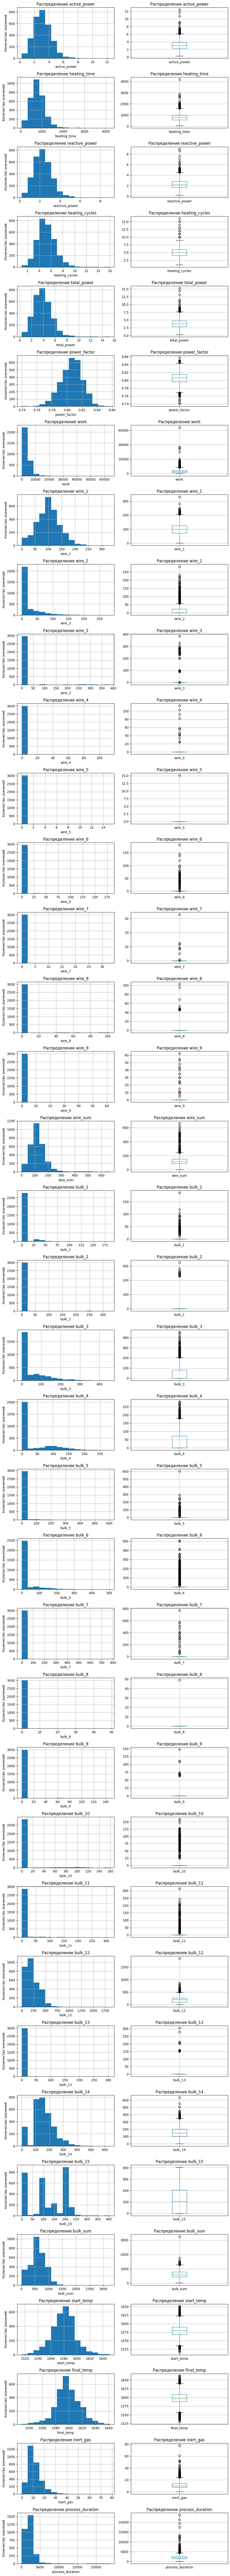

In [49]:
# Посмотрим описание получившихся данных и выведем графики распределения получившихся признаков
data_frame_info(data_df.drop('key',axis=1),['D'])
plots_hist_box(data_df.drop('key',axis=1))

В распределениях наблюдаются выбросы, особенно по объёму добавляемого присадочного материала. Это в целом ожидаемо, поскольку для различных сплавов характерно различное содержание легирующих элементов — вплоть до их полного отсутствия. Добавление легирующих компонентов может влиять как на продолжительность процесса, так и на энергозатраты, поскольку изменяются теплофизические свойства сплава.

## Корреляционный анализ

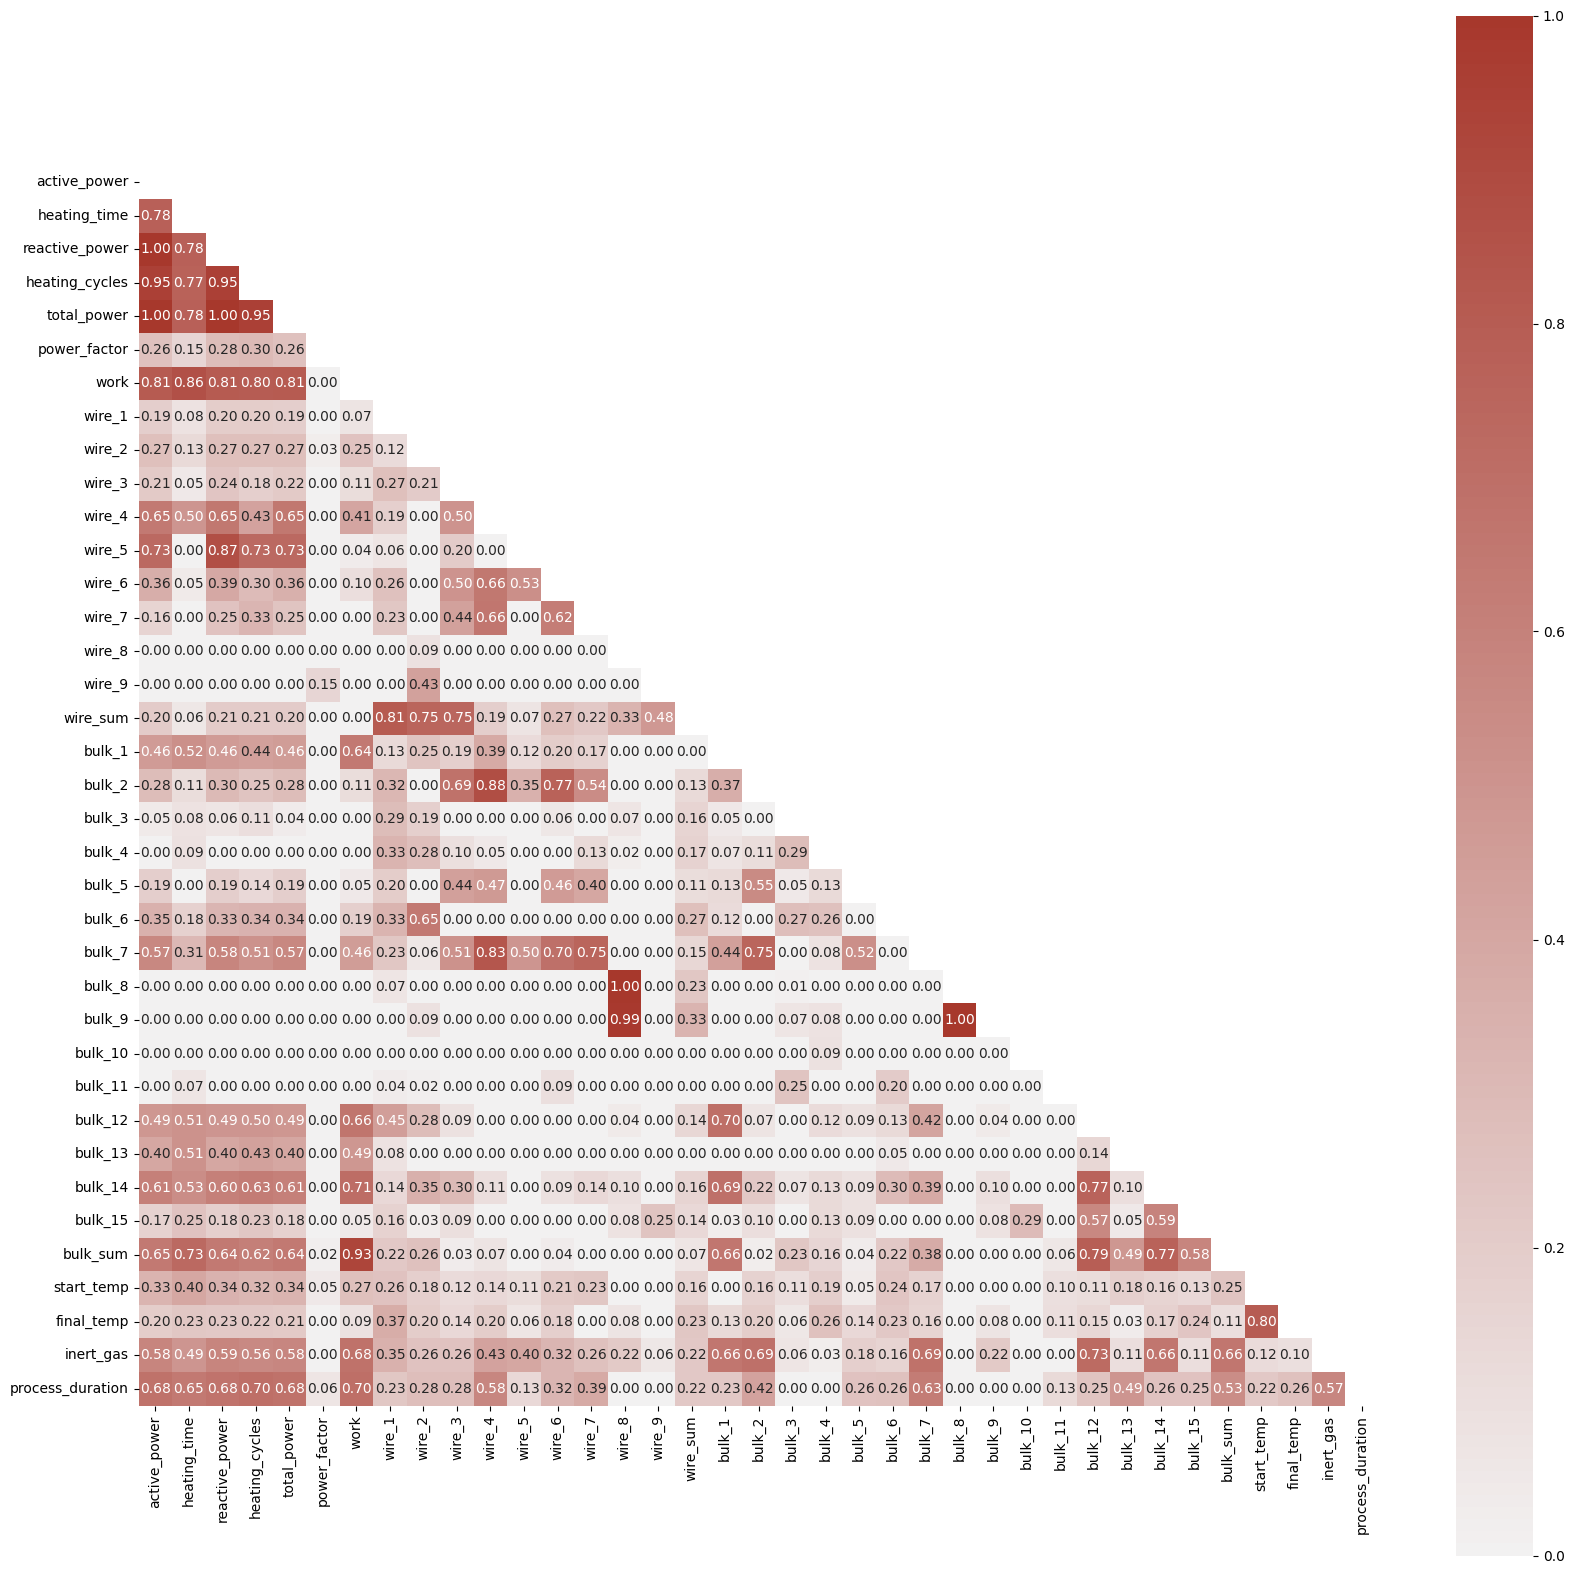

In [50]:
int_cols = data_df.drop('key',axis=1).columns
# Расчет матрицы корреляции
matrix = data_df.drop('key',axis=1).phik_matrix(interval_cols=int_cols)
# Создание маски
mask = np.triu(np.ones_like(matrix, dtype=bool))
# Создание палитры цветов
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
plt.figure(figsize=(20, 20))
sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

plt.show();

In [51]:
matrix.sort_values(by='final_temp',ascending=False)['final_temp'].head(10)

,final_temp
final_temp,1.000000
start_temp,0.800071
wire_1,0.373055
bulk_4,0.262927
process_duration,0.260234
bulk_15,0.236086
heating_time,0.233928
wire_sum,0.230131
reactive_power,0.225731
bulk_6,0.225479


Наибольшее влияние на целевой признак имеют:
* стартовая температура
* количество присадочной проволоки №1
* количество присадочного материала №4
* длительность процесса
* количество присадочного материала №15



In [52]:
# так как total_power складывается непосредственно из reactive_power и active_power и имеет большую корреляцию
# то оставим только total_power
data_df.drop(columns=['reactive_power','active_power'],axis=1,inplace=True)

## Подготовка данных

In [53]:
X_train, X_test, y_train, y_test = data_split(data_df,'final_temp',0.25)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (2265, 35)
X_test (755, 35)
y_train (2265,)
y_test (755,)


## Обучение моделей

RandomizedSearchCV

In [54]:
num_columns = X_train.drop('key', axis=1).columns
# общий пайплайн подготовки данных
data_preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 0.3, 0.5, 1.0],
        'models__penalty' : ['l1', 'l2', 'elasticnet', None],
        'models__C': [0.01, 0.1, 0.5]
    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'models__max_features': range(2, 20)
    },
    # словарь для модели XGBRegressor()
    {
        'models': [XGBRegressor(random_state = RANDOM_STATE)],
        'models__max_depth' : range(4,12),
        'models__learning_rate' : [0.01, 0.1, 0.2, 0.3],
        'models__n_estimators' : range(150,251,5)
    },
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(verbose = False, random_state = RANDOM_STATE)],
        'models__iterations' : range(3,26),
        'models__learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3],
        'models__depth' : range(3,15)
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [55]:
randomized_search.fit(X_train[num_columns], y_train)

print('Лучшая модель и параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика модели на тренировочной выборке:', abs(randomized_search.best_score_))

Лучшая модель и параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  Index(['heating_time', 'heating_cycles', 'total_power', 'power_factor', 'work',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7',
       'wire_8', 'wire_9', 'wire_sum', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
       'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', '...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
 

In [56]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__n_estimators,param_models__max_depth,param_models__learning_rate,param_models,param_models__iterations,param_models__depth,param_models__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.505612,0.022429,0.010798,0.000298,160.0,4.0,0.30,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,NaN,"{'models__n_estimators': 160, 'models__max_dep...",-8.954802,-8.946121,-9.471986,-8.830849,-8.684859,-8.977723,0.265767,1
6,8.819934,0.259391,0.022240,0.006151,185.0,9.0,0.01,"XGBRegressor(base_score=None, booster=None, ca...",NaN,NaN,NaN,"{'models__n_estimators': 185, 'models__max_dep...",-9.140938,-9.302772,-9.643136,-9.385118,-9.181407,-9.330674,0.178693,2
5,10.271932,1.261020,0.009292,0.000878,NaN,NaN,0.20,<catboost.core.CatBoostRegressor object at 0x7...,24.0,12.0,NaN,"{'models__learning_rate': 0.2, 'models__iterat...",-9.368890,-9.706752,-9.784186,-9.440976,-9.266897,-9.513540,0.198798,3
2,0.103391,0.007798,0.012061,0.003204,NaN,NaN,0.30,<catboost.core.CatBoostRegressor object at 0x7...,23.0,3.0,NaN,"{'models__learning_rate': 0.3, 'models__iterat...",-9.379929,-9.695813,-9.695202,-9.352083,-9.469808,-9.518567,0.149620,4
3,0.091548,0.004467,0.011261,0.003411,NaN,NaN,0.30,<catboost.core.CatBoostRegressor object at 0x7...,16.0,3.0,NaN,"{'models__learning_rate': 0.3, 'models__iterat...",-9.481042,-9.770701,-9.773671,-9.380979,-9.630910,-9.607460,0.156268,5
7,0.206888,0.031776,0.013825,0.006071,NaN,NaN,0.10,<catboost.core.CatBoostRegressor object at 0x7...,22.0,4.0,NaN,"{'models__learning_rate': 0.1, 'models__iterat...",-9.774121,-9.989763,-10.010151,-9.801285,-9.687199,-9.852504,0.126322,6
1,0.131931,0.043329,0.008295,0.001288,NaN,NaN,0.20,<catboost.core.CatBoostRegressor object at 0x7...,10.0,5.0,NaN,"{'models__learning_rate': 0.2, 'models__iterat...",-9.849677,-9.950670,-9.977537,-9.807941,-9.698675,-9.856900,0.100827,7
9,0.294750,0.021594,0.008529,0.002705,NaN,NaN,0.05,<catboost.core.CatBoostRegressor object at 0x7...,25.0,6.0,NaN,"{'models__learning_rate': 0.05, 'models__itera...",-10.356970,-10.302178,-10.299538,-10.254373,-9.972815,-10.237175,0.136123,8
4,0.342792,0.027735,0.013501,0.002909,NaN,NaN,0.10,<catboost.core.CatBoostRegressor object at 0x7...,10.0,8.0,NaN,"{'models__learning_rate': 0.1, 'models__iterat...",-10.544994,-10.610207,-10.647874,-10.539482,-10.015229,-10.471557,0.231756,9
8,0.042625,0.001277,0.006826,0.000428,NaN,19.0,NaN,DecisionTreeRegressor(random_state=42),NaN,NaN,14.0,"{'models__max_features': 14, 'models__max_dept...",-11.717374,-12.360092,-13.111297,-12.241481,-13.142248,-12.514499,0.544798,10


In [57]:
y_predict = randomized_search.predict(X_test[num_columns])
print(f'MAE: {mean_absolute_error(y_test, y_predict)}')

MAE: 9.202842702297186


Optuna

In [58]:
# Определение функции для подбора модели и гиперпараметров
def objective(trial):
    # Выбор модели
    model_name = trial.suggest_categorical('model', ['LogisticRegression', 'DecisionTreeRegressor', 'XGBRegressor', 'CatBoostRegressor', 'RandomForestRegressor', 'SVR'])

    if model_name == 'LogisticRegression':
        model = LogisticRegression(
            C=trial.suggest_loguniform('logistic_C', 1e-5, 1e2),
            solver='liblinear'
        )
    elif model_name == 'DecisionTreeRegressor':
        model = DecisionTreeRegressor(
            max_depth=trial.suggest_int('dt_max_depth', 2, 32),
            min_samples_split=trial.suggest_int('dt_min_samples_split', 2, 20)
        )
    elif model_name == 'XGBRegressor':
        model = XGBRegressor(
            n_estimators=trial.suggest_int('xgb_n_estimators', 100, 1000),
            learning_rate=trial.suggest_loguniform('xgb_learning_rate', 1e-5, 1e-1),
            max_depth=trial.suggest_int('xgb_max_depth', 2, 10),
            subsample=trial.suggest_uniform('xgb_subsample', 0.5, 1.0)
        )
    elif model_name == 'CatBoostRegressor':
        model = CatBoostRegressor(
            iterations=trial.suggest_int('cb_iterations', 100, 1000),
            learning_rate=trial.suggest_loguniform('cb_learning_rate', 1e-5, 1e-1),
            depth=trial.suggest_int('cb_depth', 2, 10),
            verbose=0  # Отключение вывода логов CatBoost
        )
    elif model_name == 'RandomForestRegressor':
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int('rf_n_estimators', 100, 1000),
            max_depth=trial.suggest_int('rf_max_depth', 2, 32),
            min_samples_split=trial.suggest_int('rf_min_samples_split', 2, 20)
        )
    elif model_name == 'SVR':
        model = SVR(
            C=trial.suggest_loguniform('svr_C', 1e-5, 1e2),
            gamma=trial.suggest_loguniform('svr_gamma', 1e-5, 1e2)
        )

    # Создание pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Оценка модели
    score = cross_val_score(pipeline, X_train.drop('key',axis=1), y_train, cv=3, scoring='neg_mean_absolute_error').mean()
    return score

# Создание и запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод лучших параметров
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-02-16 12:05:04,866] A new study created in memory with name: no-name-ab00af5d-8063-4f47-9dbd-1b1a486ffd3d
/tmp/ipython-input-2583841954.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform('svr_C', 1e-5, 1e2),
/tmp/ipython-input-2583841954.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma=trial.suggest_loguniform('svr_gamma', 1e-5, 1e2)
[I 2026-02-16 12:05:05,664] Trial 0 finished with value: -13.667329496310439 and parameters: {'model': 'SVR', 'svr_C': 7.48081893577123e-05, 'svr_gamma': 40.29600931616124}. Best is trial 0 with value: -13.667329496310439.
/tmp/ipython-input-2583841954.py:8: FutureWarning: suggest_loguniform ha

Best trial:
  Value: -8.570418240376656
  Params: 
    model: XGBRegressor
    xgb_n_estimators: 870
    xgb_learning_rate: 0.022714448505951813
    xgb_max_depth: 5
    xgb_subsample: 0.8645160538580634


### Нейронная сеть

In [59]:
# Останавливаем тренеровку, если потери не улучшаются
class training_stop():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#Создадим класс для задания архитектуры нейронной сети с переменным количеством скрытых слоев
class CustomNeuralNetwork(nn.Module):
    def __init__(self, n_neurons, act_funcs, drop_out_p = 0.3):
        super(CustomNeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.act_fun = act_funcs
        self.drop_out_p = drop_out_p

        # Добавим скрытые слои
        for i in range(1,len(n_neurons)):
            self.layers.append(nn.Linear(n_neurons[i-1], n_neurons[i]))
            for act in act_funcs[i-1]:
                if act == 'Sigmoid':
                    self.layers.append(nn.Sigmoid())
                elif act == 'Tanh':
                    self.layers.append(nn.Tanh())
                elif act == 'ReLU':
                    self.layers.append(nn.ReLU())
                elif act == 'BatchNorm1d':
                    self.layers.append(nn.BatchNorm1d(n_neurons[i]))
                elif act == 'Dropout':
                    self.layers.append(nn.Dropout(p=drop_out_p))
                elif act == 'LeakyReLU':
                    self.layers.append(nn.LeakyReLU())
                else:
                    self.layers.append(nn.ReLU())

    def get_acts(self):
        return self.act_fun

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def train_model(model, X, y, epochs=10000, epoch_step = 100, batch_size=32,
                test_size=0.15, k_folds=5,lr=1e-3, stop_func=training_stop):
    device='cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    # Книга для хранения лучшего результата
    best_results = {'neurons': [],
                'MAE'     : 20000,
                'acts': [],
                'dropout_p': []
               }
    results = pd.DataFrame({'Нейроны': [],
                        'Функции активации': [],
                        'Батчи': [],
                        'MAE': [],
                        'drop_out_p': []
                       })
    kfold = KFold(n_splits=k_folds, shuffle=True)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(),lr=lr)

    # Разделение данных на обучающую и валидационную выборки
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()

        val_loss /= len(val_loader)

        if epoch % epoch_step == 0:
            if stop_func.counter == 0:
                best_mae = val_loss
                if best_results['MAE'] > best_mae:
                    best_results['neurons'] = neurons
                    best_results['acts'] = model.act_fun[0:len(neurons)]
                    best_results['MAE'] = best_mae
            print(f"Эпоха: [{epoch}/{epochs-1}] | MAE:",round(val_loss,3))
            stop_func(val_loss)
            if stop_func.early_stop:
                print('Остановка, улучшений потерь нет \n')
                if any('Dropout' in a for a in model.act_fun):
                    new_row = pd.DataFrame({'Нейроны': [neurons],
                                                           'Функции активации': [model.act_fun[0:len(neurons)]],
                                                           'Батчи': batch_size,
                                                           'MAE': best_mae,
                                                           'drop_out_p': model.drop_out_p})
                    results = pd.concat([results, new_row], ignore_index = True)
                else:
                    new_row = pd.DataFrame({'Нейроны': [neurons],
                                                           'Функции активации': [model.act_fun[0:len(neurons)]],
                                                           'Батчи': batch_size,
                                                           'MAE': best_mae,
                                                           'drop_out_p': 0})
                    results = pd.concat([results, new_row], ignore_index = True)
                break
    return results

In [60]:
# Отскалируем признаки
data_preprocessor.fit(X_train.drop('key', axis=1))
X_train_scaled = data_preprocessor.transform(X_train.drop('key',axis=1))
X_test_scaled = data_preprocessor.transform(X_test.drop('key',axis=1))

# Пример данных
X = torch.FloatTensor(np.array(X_train_scaled))
y = torch.FloatTensor(np.array(y_train))

#Выберем количество скрытых слоёв и количество нейронов на них
n_neurons = [[X.shape[1], 15, 1],
             [X.shape[1], 13, 8, 1],
             [X.shape[1], 12, 1],
             [X.shape[1], 11, 1],
             [X.shape[1], 10, 1]
            ]

act_funcs = [
    [['ReLU'],['ReLU'],['ReLU'],['ReLU'],['ReLU']],
    [['BatchNorm1d'], ['LeakyReLU'], ['ReLU'], ['ReLU']]
            ]


results = pd.DataFrame({'Нейроны': [],
                        'Функции активации': [],
                        'Батчи': [],
                        'MAE': [],
                        'drop_out_p': []
                       })

for neurons in n_neurons:
    for act in act_funcs:
        print('Количество нейронов по слоям:',neurons)
        print('Функции активации в слоях',act[0:len(neurons)])
        model = CustomNeuralNetwork(neurons, act)
        new_row = train_model(model, X, y, epochs=5001,
            epoch_step = 100,
            batch_size=40,
            lr=1e-3,
            k_folds=5,
            stop_func = training_stop(patience=5, min_delta=0.5))

        results = pd.concat([results, new_row], ignore_index = True)

Количество нейронов по слоям: [34, 15, 1]
Функции активации в слоях [['ReLU'], ['ReLU'], ['ReLU']]


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:132: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, targ

Эпоха: [0/5000] | MAE: 1597.739
Эпоха: [100/5000] | MAE: 234.904
Эпоха: [200/5000] | MAE: 165.446
Эпоха: [300/5000] | MAE: 110.848
Эпоха: [400/5000] | MAE: 84.885
Эпоха: [500/5000] | MAE: 66.188
Эпоха: [600/5000] | MAE: 48.484
Эпоха: [700/5000] | MAE: 30.34
Эпоха: [800/5000] | MAE: 16.984
Эпоха: [900/5000] | MAE: 14.045
Эпоха: [1000/5000] | MAE: 13.389
Эпоха: [1100/5000] | MAE: 13.147
Эпоха: [1200/5000] | MAE: 13.031
Эпоха: [1300/5000] | MAE: 12.9
Эпоха: [1400/5000] | MAE: 12.849
Эпоха: [1500/5000] | MAE: 12.745
Эпоха: [1600/5000] | MAE: 12.698
Эпоха: [1700/5000] | MAE: 12.863
Эпоха: [1800/5000] | MAE: 12.615
Эпоха: [1900/5000] | MAE: 12.58
Остановка, улучшений потерь нет 

Количество нейронов по слоям: [34, 15, 1]
Функции активации в слоях [['BatchNorm1d'], ['LeakyReLU'], ['ReLU']]
Эпоха: [0/5000] | MAE: 1597.698
Эпоха: [100/5000] | MAE: 761.412
Эпоха: [200/5000] | MAE: 130.183
Эпоха: [300/5000] | MAE: 104.251
Эпоха: [400/5000] | MAE: 134.389
Эпоха: [500/5000] | MAE: 99.769
Эпоха: [60

In [61]:
results.sort_values(by='MAE',ascending=True)

,Нейроны,Функции активации,Батчи,MAE,drop_out_p
7,"[34, 11, 1]","[[BatchNorm1d], [LeakyReLU], [ReLU]]",40.0,12.512726,0.0
1,"[34, 15, 1]","[[BatchNorm1d], [LeakyReLU], [ReLU]]",40.0,12.519360,0.0
9,"[34, 10, 1]","[[BatchNorm1d], [LeakyReLU], [ReLU]]",40.0,12.529673,0.0
5,"[34, 12, 1]","[[BatchNorm1d], [LeakyReLU], [ReLU]]",40.0,12.549185,0.0
0,"[34, 15, 1]","[[ReLU], [ReLU], [ReLU]]",40.0,12.744541,0.0
2,"[34, 13, 8, 1]","[[ReLU], [ReLU], [ReLU], [ReLU]]",40.0,12.750828,0.0
4,"[34, 12, 1]","[[ReLU], [ReLU], [ReLU]]",40.0,12.762545,0.0
6,"[34, 11, 1]","[[ReLU], [ReLU], [ReLU]]",40.0,13.005896,0.0
3,"[34, 13, 8, 1]","[[BatchNorm1d], [LeakyReLU], [ReLU], [ReLU]]",40.0,13.171405,0.0
8,"[34, 10, 1]","[[ReLU], [ReLU], [ReLU]]",40.0,1597.997206,0.0


In [62]:
best_model = XGBRegressor(random_state=RANDOM_STATE,
                          n_estimators=374,
                          max_depth=6,
                          learning_rate=0.03873113953547494,
                          subsample=0.7427956235972775)
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print("MAE on test set: {}".format(round(mae,4)))

MAE on test set: 8.8633


Константная модель — это модель, которая предсказывает одно и то же значение вне зависимости от входных признаков. В машинном обучении она используется как базовая модель (baseline) для сравнения с более сложными алгоритмами. В нашем случае такая модель будет возвращать среднее значение по столбцу final_temp для любого объекта.

In [63]:
constant_answer = y_train.mean()
test_n_preds = pd.DataFrame({'true': y_test,
                             'predict': y_pred,
                             'constant_mean': constant_answer,
                             'error': y_test.values-y_pred,
                             'constant_error' : y_test.values-constant_answer
                            })

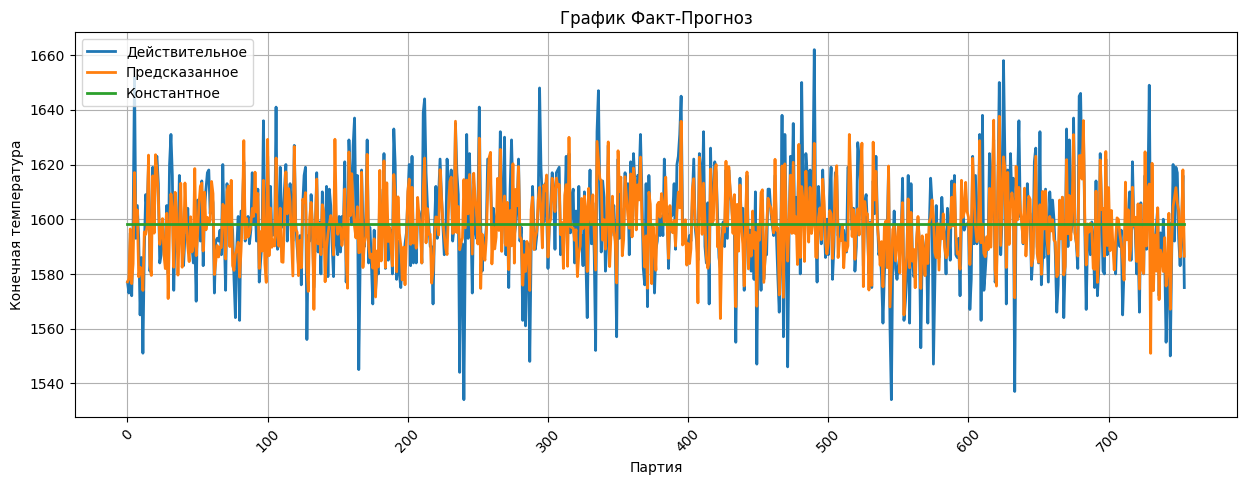

In [64]:
plt.figure(figsize=(15, 5))

plt.plot(test_n_preds.true.values, linewidth=2, label='Действительное')
plt.plot(test_n_preds.predict.values, linewidth=2, label='Предсказанное')
plt.plot(test_n_preds.constant_mean.values, linewidth=2, label='Константное')

plt.title("График Факт-Прогноз")
plt.xlabel("Партия")
plt.ylabel("Конечная температура")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show();

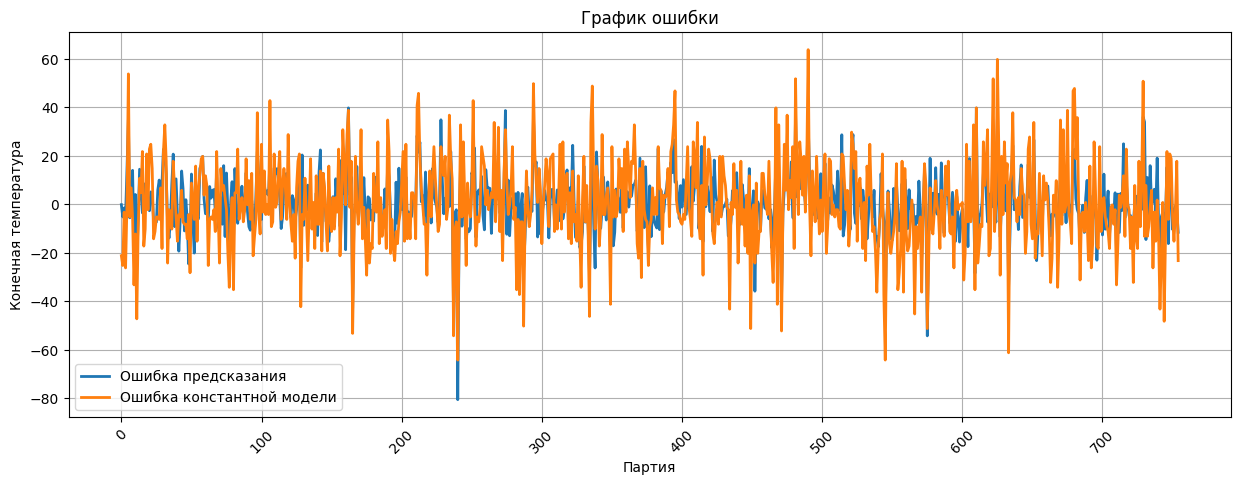

In [65]:
plt.figure(figsize=(15, 5))
plt.plot(test_n_preds['error'].values, linewidth=2, label='Ошибка предсказания')
plt.plot(test_n_preds['constant_error'].values, linewidth=2, label='Ошибка константной модели')
plt.title("График ошибки")
plt.xlabel("Партия")
plt.ylabel("Конечная температура")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show();

In [66]:
test_n_preds[['error','constant_error']].describe()

,error,constant_error
count,755.000000,755.000000
mean,0.409982,0.113907
std,12.113926,18.557634
min,-80.494019,-64.156291
25%,-6.407654,-10.156291
50%,-0.278076,-2.156291
75%,6.913940,11.843709
max,39.826294,63.843709


## Анализ важности признаков

  0%|          | 0/10 [00:00<?, ?it/s]

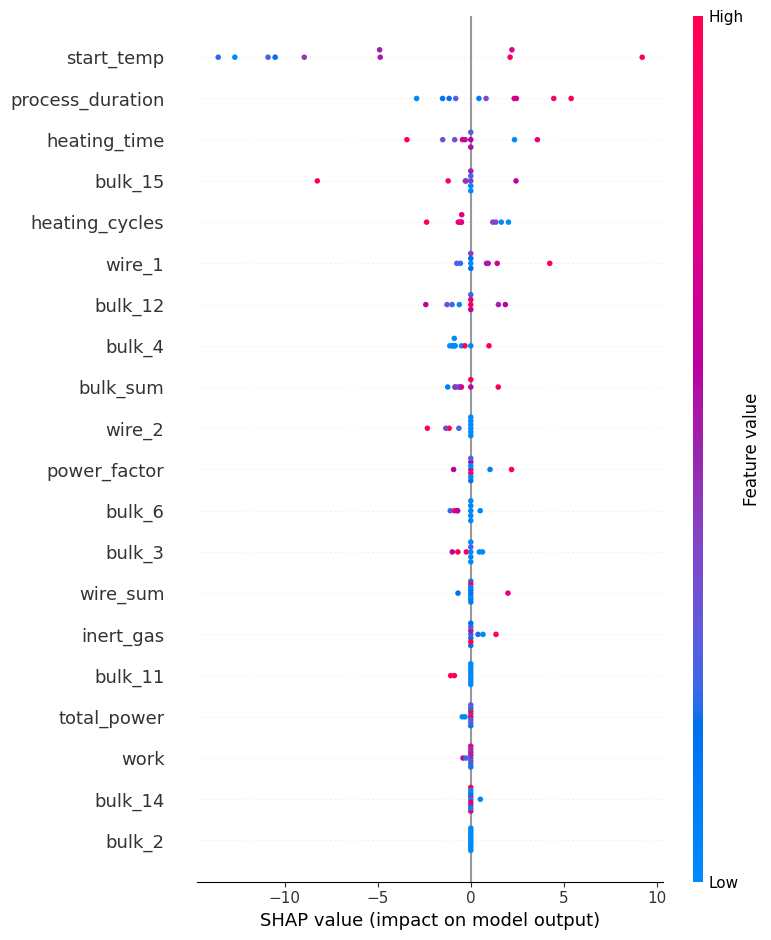

In [67]:
# Объединяем все имена признаков
all_feature_names = X_train.drop('key',axis=1).columns

# DataFrame с именами колонок
X_train_preprocessed_df = pd.DataFrame(X_train_scaled, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_scaled, columns=all_feature_names)

# Семпл для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, 10, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, 10, random_state=RANDOM_STATE)

# Используем KernelExplainer
explainer = shap.KernelExplainer(best_model.predict, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

# Построение графика с именами признаков
shap.summary_plot(shap_values, X_test_preprocessed_smpl)

Топ 5 признаков влияющих на результат это:
* начальная температура
* продолжительность процесса
* время нагрева
* количество присадочной материала №15
* циклы нагрева

Но совпадают с корреляционным анализом только пункты:
* начальная температура
* продолжительность процесса
* количество присадочного материала № 15

### Выводы

В ходе подбора моделей наилучший результат продемонстрировал **XGBRegressor**.  
Значение метрики MAE составило **8.629** на обучающей выборке и **8.8633** на тестовой.  
Однако полученный результат не удовлетворяет условию задачи (**MAE < 6.8**).

Константная модель показала более низкое качество: средняя ошибка составляет порядка ±10 °C,
а максимальное отклонение достигает 64 °C.

Сравнение предсказаний с фактическими значениями показало, что максимальное отклонение модели
от реальной температуры составило 80 °C, тогда как типичное отклонение находится в пределах ±7 °C.

Результаты корреляционного анализа в целом согласуются с анализом важности признаков,
что подтверждает логичность полученных выводов.

---

### Выполненные преобразования данных

В процессе поиска оптимального решения были выполнены следующие действия:

- удалены отдельные признаки `bulk` и `wire` с сохранением их агрегированных значений;
- исключены аномальные значения на этапе обработки `data_arc`;
- добавлены суммарные признаки для материалов `bulk` и `wire`.
